<a href="https://colab.research.google.com/github/rahimizadeh/Deep-Transfer-Learning-for-Weeds-Classifier/blob/main/Weeds_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weeds Deep Learning 

    The following code is the implementation of the Weeds Deep Learning. 
      
    Copyright 2022 Keyvan RahimiZadeh . All Rights Reserved.
    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at
        http://www.apache.org/licenses/LICENSE-2.0
    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.



In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
import argparse 
#import session_info
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
import csv
import tensorflow as tf
from tensorflow import keras
import time
from tensorflow.python.ops.math_ops import multiply
from google.colab import drive

from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet import EfficientNet
from keras.applications.efficientnet_v2 import EfficientNetV2
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v3 import MobileNetV3
from keras.applications.vgg19 import VGG19 
from keras.applications.vgg16 import VGG16 
from keras.applications.inception_resnet_v2 import InceptionResNetV2 
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101
from keras.applications.resnet import ResNet152 


In [ ]:

drive.mount("/tmp/drive")
! unzip "/tmp/drive/MyDrive/data/Weeds Dataset.zip"  -d /tmp/Weeds_DS 
! ls /tmp/Weeds_DS

Mounted at /tmp/drive
Archive:  /tmp/drive/MyDrive/data/Weeds Dataset.zip
   creating: /tmp/Weeds_DS/Weeds Dataset/0/
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/1.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/10.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/100.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/101.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/102.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/103.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/104.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/105.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/106.jpeg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/107.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/108.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/109.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/11.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/110.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/111.jpg  
  inflating: /tmp/Weeds_DS/Weeds Dataset/0/112.jpg  
  inflating: /tmp/Weeds_DS/Weeds Data

In [ ]:
images_class = { 'Class_0' : 0,
                'Class_1' : 1,  
                'Class_2' : 2,
                'Class_3' : 3,
                'Class_4' : 4,
                'Class_5' : 5,
                'Class_6' : 6,
                'Class_7' : 7,
                'Class_8' : 8,
                'Class_9' : 9,
                'Class_10' : 10,
                'Class_11' : 11 }


In [ ]:
def image_laoder_X():
      total_sample_size = 0
      class_distribution = {}
      all_images_path = {}
      for class_id in images_class:
           path_ = '/tmp/Weeds_DS/Weeds Dataset/{}/*.*'.format(images_class[class_id])
           all_images_path[class_id] = glob(path_)
           class_distribution[class_id] = len(all_images_path[class_id])
           total_sample_size = total_sample_size + len(all_images_path[class_id])
           
      
      return all_images_path, total_sample_size,class_distribution


In [ ]:
# Data Aug
datagen = ImageDataGenerator(
        rotation_range=90,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        #fill_mode='nearest'
        )

#-------- Laod images -------
all_images_path, total_sample_size,class_distribution = image_laoder_X()

#
clss = 0
images_path_tmp = all_images_path.copy()

aug_rate = 1
for label in images_path_tmp: # for each class
    for image_path in images_path_tmp[label]:
      image = cv2.imread(image_path)
      image = cv2.resize(image,(229, 229))
      #X.append(image)
      X = img_to_array(image)
      X = X.reshape((1,) + X.shape)
      #-----------------
      # the .flow() command below generates batches of randomly transformed images
      # and saves the results to the `preview/` directory
      prfx = 'aug'
      targ_path = '/tmp/Weeds_DS/Weeds Dataset/{}'.format(images_class[label])
      i = 0
      
      for batch in datagen.flow(X, batch_size=1,
                          save_to_dir= targ_path, save_prefix= prfx, save_format='png'):
         i += 1
         if i > aug_rate:
            break  # otherwise the generator would loop indefinitely

    clss +=1         

In [ ]:
def Dataset_loader():
   
   
    #------------------------------------------------------
   all_images_path, total_sample_size, class_distribution = image_laoder_X()


   images = []
   labels = []

   for label in all_images_path:
        for image_path in all_images_path[label]:
            image = cv2.imread(image_path)
            image = cv2.resize(image,(299, 299))
            images.append(image)
            labels.append(images_class[label])  

   images = np.array(images)
   labels = np.array(labels)


   return images, labels, total_sample_size, class_distribution

In [ ]:
X_ , Y_, total_sample_size, class_distribution = Dataset_loader()
indxs = np.linspace(0,total_sample_size-1,total_sample_size,dtype='int32')
np.random.shuffle(indxs)


train_size=0.75
train_end_indx = int(train_size*total_sample_size)
train_indxs = indxs[0:train_end_indx-1] #train_indxs_xx #
test_indxs = indxs[train_end_indx:-1] #test_indxs_xx #

X_train = X_[train_indxs]
Y_train = Y_[train_indxs]
X_test = X_[test_indxs]
Y_test = Y_[test_indxs]

del(X_)


(299, 299, 3)


([<matplotlib.patches.Wedge at 0x7fea025e01d0>,
 [Text(1.2172662539173293, 0.32536574354727626, 'Class_0'),
  Text(0.8925917877238203, 0.8893142866770973, 'Class_1'),
  Text(0.3280516752665735, 1.216545148506538, 'Class_2'),
  Text(-0.32805173221716144, 1.2165451331493295, 'Class_3'),
  Text(-0.8879999099105703, 0.8938994126851293, 'Class_4'),
  Text(-1.2138503829471785, 0.33788644219469366, 'Class_5'),
  Text(-1.2198595774895593, -0.3155037419857231, 'Class_6'),
  Text(-0.8984609120527601, -0.8833843951040353, 'Class_7'),
  Text(-0.3325247934969092, -1.2153301040087165, 'Class_8'),
  Text(0.32626119290307715, -1.2170265543551058, 'Class_9'),
  Text(0.8906267170395941, -0.891282250970631, 'Class_10'),
  Text(1.216545140827934, -0.3280517037418681, 'Class_11')])

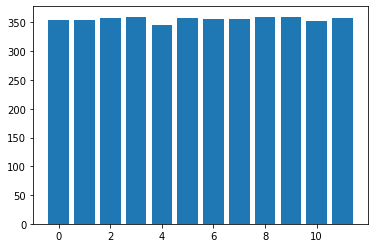

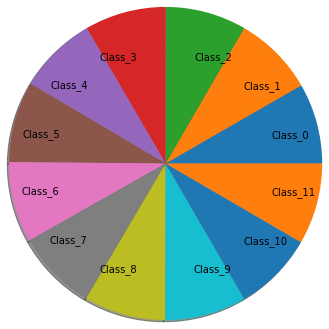

In [ ]:
num_of_classes = len(images_class)
input_shape = np.shape(X_train)[1:]
print(input_shape)

Dist_ = [class_distribution[clss] for clss in class_distribution]
x = np.linspace(0,num_of_classes-1,num_of_classes)
plt.figure(figsize=(6,4))
plt.bar(x,Dist_)

Labels = [clss for clss in class_distribution]
plt.figure()
plt.pie(Dist_,labels=Labels, radius=1.8, shadow=True, labeldistance=0.7)

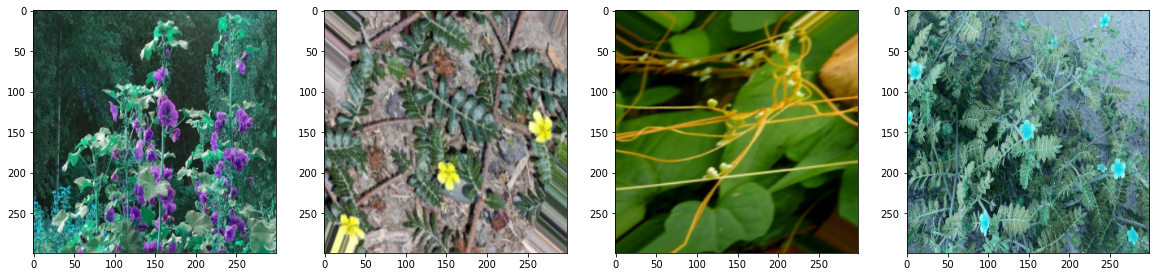

In [ ]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#fig.suptitle('') 
fig.set_size_inches((20,20))
ax1.imshow(X_train[0])
ax2.imshow(X_train[5])
ax3.imshow(X_train[50])
ax4.imshow(X_train[70])
plt.show()

In [ ]:
# Scaling data
X_train = X_train.astype("float32") / 255
#Y_train = tf.keras.utils.to_categorical(Y_train, num_of_classes)

X_test = X_test.astype("float32") / 255
#Y_test =  tf.keras.utils.to_categorical(Y_test, num_of_classes)

#X_train = np.expand_dims(X_train, -1)
#X_test = np.expand_dims(X_test, -1)

In [ ]:
# initial pre trained model
pre_trained_models = {}

pre_trained_models["DenseNet169"] = DenseNet169(include_top=False, input_shape=(299, 299, 3), pooling="avg")
#pre_trained_models["InceptionResNetV2"] = InceptionResNetV2(include_top=False, input_shape=(299, 299, 3), pooling="avg")
#pre_trained_models["ResNet50"] = ResNet50(include_top=False, input_shape=(299, 299, 3), pooling="avg")
#pre_trained_models["VGG19"] = VGG19(include_top=False, input_shape=(299, 299, 3), pooling="avg")

51888128/51877672 [==============================] - 0s 0us/step


In [ ]:
X_train = pre_trained_models["DenseNet169"].predict(X_train)
X_test = pre_trained_models["DenseNet169"].predict(X_test)

#X_train_x = pre_trained_models["InceptionResNetV2"].predict(X_train)
#X_test_x = pre_trained_models["InceptionResNetV2"].predict(X_test)

#X_train_x = pre_trained_models["ResNet50"].predict(X_train)
#X_test_x = pre_trained_models["ResNet50"].predict(X_test)

#X_train_x = pre_trained_models["VGG19"].predict(X_train)
#X_test_x = pre_trained_models["VGG19"].predict(X_test)


In [ ]:
inp_shape = X_train.shape[1]
# Model 1
model1 = keras.Sequential()
model1.add(keras.Input(shape=(inp_shape)))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(200,activation='relu'))
model1.add(keras.layers.Dense(100,activation='relu'))
#model1.add(keras.layers.BatchNormalization()) 
model1.add(keras.layers.Dense(num_of_classes,activation='softmax'))
#model1.add(keras.layers.Dense(1,activation='sigmoid'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 1664)              0         
                                                                 
 dense_6 (Dense)             (None, 200)               333000    
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 12)                1212      
                                                                 
Total params: 354,312
Trainable params: 354,312
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if (logs.get('accuracy')>= 0.998): 
          print('\nStop training at 99.8% accuracy')
          self.model.stop_training = True

In [ ]:
batch_size = 32
lr = 0.01


opt = keras.optimizers.SGD(learning_rate=lr,momentum=0.9)
#opt = keras.optimizers.Adam(learning_rate=lr)
#opt = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9, momentum=0.0, epsilon=1e-07)

callbacks = MyCallback()

# ---- bin class ---------
#model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#history = model1.fit(X_train, Y_tr_bin, validation_split=0.1, batch_size=batch_size, shuffle=True, epochs=500, callbacks=[callbacks])
#model1.evaluate(X_test, Y_ts_bin)
# ---- mult class ---------
Y_train_m = tf.keras.utils.to_categorical(Y_train,num_of_classes)
Y_test_m = tf.keras.utils.to_categorical(Y_test,num_of_classes)

model1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model1.fit(X_train, Y_train_m, validation_split=0.1, batch_size=batch_size, shuffle=True, epochs=300, callbacks=[callbacks])
model1.evaluate(X_test, Y_test_m)
#---------------------------

Epoch 1/300
90/90 [==============================] - 1s 6ms/step - loss: 1.4838 - accuracy: 0.5082 - val_loss: 0.9351 - val_accuracy: 0.7031
Epoch 2/300
90/90 [==============================] - 0s 3ms/step - loss: 0.7887 - accuracy: 0.7449 - val_loss: 0.6052 - val_accuracy: 0.8094
Epoch 3/300
90/90 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.7845 - val_loss: 0.6057 - val_accuracy: 0.7875
Epoch 4/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5560 - accuracy: 0.8100 - val_loss: 0.5260 - val_accuracy: 0.8156
Epoch 5/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5058 - accuracy: 0.8301 - val_loss: 0.5030 - val_accuracy: 0.8313
Epoch 6/300
90/90 [==============================] - 0s 3ms/step - loss: 0.4538 - accuracy: 0.8458 - val_loss: 0.5050 - val_accuracy: 0.8562
Epoch 7/300
90/90 [==============================] - 0s 3ms/step - loss: 0.3985 - accuracy: 0.8719 - val_loss: 0.4724 - val_accuracy: 0.8344
Epoch 8/300
9

[0.27777761220932007, 0.9360902309417725]

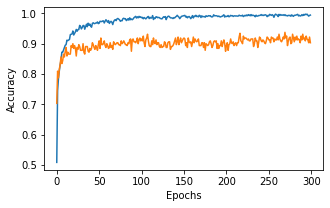

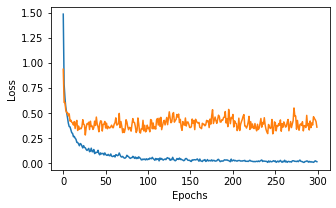

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(5,3))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(tr_acc)
plt.plot(val_acc)

plt.figure(figsize=(5,3))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(tr_loss)
plt.plot(val_loss)

Y_pred_cate = model1.predict(X_test)

In [ ]:
import csv
from google.colab import files
# open the file in the write mode
#f_name = 'log_Inception_ResNetv2'
f_name = 'log_DenseNet169_aug'
f = open('./{}.csv'.format(f_name), 'w')

# create the csv writer
writer = csv.writer(f)
writer.writerow(['Ephochs', 'accuracy',  'val_accuracy', 'loss', 'val_loss'])
Epochs = len(tr_acc)
for i in range(Epochs):
       row = [i, tr_acc[i], val_acc[i], tr_loss[i], val_loss[i]]
       # write a row to the csv file
       writer.writerow(row)

# close the file
f.close()

files.download('{}.csv'.format(f_name))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>